In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import sympy as sp

Model presentation

$$
\begin{align*}
\dot{S_j}(t) &= -\beta S_j(t) I_j(t) - \eta_j S_j(t) + \sum_{k \sim j} \eta_k\frac{A_{jk}}{N_k}\frac{P_k}{P_j}S_k(t - \delta_{ij}) - u_j(t)S_j(t) \\
\dot{I_j}(t) &= \beta S_j(t) I_j(t) - \eta_j I_j(t) + \sum_{k \sim j} \eta_k\frac{A_{jk}}{N_k}\frac{P_k}{P_j}I_k(t - \delta_{ij}) - \gamma I_j(t) \\
\dot{R_j}(t) &= \gamma I_j(t) - \eta_j R_j(t) + \sum_{k \sim j} \eta_k\frac{A_{jk}}{N_k}\frac{P_k}{P_j}R_k(t - \delta_{ij}) + u_j(t) S_j(t), 
\end{align*}
$$

such that $P_j$ is the population size of the $j$-th city and $N_j$ is the number of neighbours. We define $A_{ij}$ as the adjacency matrix. Finally $\delta_{ij}$ is the delay of transition between cities.

We can denote 

$$
A_{jk} = \begin{cases}
    \frac{P_k}{N_k P_j} &\text{if } j \sim k \\
    0 &\text{c.c.}
\end{cases}
$$

In [54]:
def model_ode(t, y, beta, gamma, eta, A, u, N_cities): 
    s_dot = np.zeros(N_cities)
    i_dot = np.zeros_like(s_dot)
    r_dot = np.zeros_like(i_dot)
    for j in range(N_cities):
        s_dot[j] = -beta * y[j] * y[j+N_cities] - eta[j] * y[j] + (A[j,:]*eta*y[:N_cities]).sum() - u(t)[j] * y[j]
        i_dot[j] = beta * y[j] * y[j+N_cities] - eta[j] * y[j+N_cities] + (A[j,:]*eta*y[N_cities:2*N_cities]).sum() - gamma * y[j+N_cities]
        r_dot[j] = gamma * y[j+N_cities] + u(t)[j] * y[j] - eta[j] * y[j+2*N_cities] + (A[j,:]*eta*y[2*N_cities:]).sum()
    return np.hstack([s_dot, i_dot, r_dot])

Modelling the city structure: we have a capital, and $n$ cities around.

We consider that we have $n-1$ periferic cities with $P_j$ each one, and a capital with $P_0$. The matrix will be 

$$
A = \begin{bmatrix}
    0 & 1 & 1 & 1 & \cdots & 1 \\
    1 & 0 & 0 & 0 & \cdots & 0 \\
    1 & 0 & 0 & 0 & \cdots & 0 \\
    1 & 0 & 0 & 0 & \cdots & 0 \\
    \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
    1 & 0 & 0 & 0 & \cdots & 0
\end{bmatrix}
$$

Then

In [55]:
def create_matrix(n, P1, PJ):
    A = np.zeros((n,n))
    A[0,:]=1
    A[:,0]=1
    A[0,0]=0
    for j in range(1,n):
        # Nj = 1
        A[0,j] = PJ/P1
        A[j,0] = P1/PJ/(n-1)
    return A

We are going to set $\delta_{ij} = 0$ for now. Moreover $\eta_j = \sum_{} A_{jk}\eta_k$. In this network structure $\eta_j = A_{j0} \eta_0$ for $j=1,\dots,n-1$ and $\eta_0 = \sum_{k=1}^{n-1} A_{0k} \eta_k$. It remains to define $\eta_0$. 

In [56]:
N_cities = 10
A = create_matrix(n=N_cities, P1=1e6, PJ=1e4)
beta = 0.7
gamma = 0.25

eta = np.zeros(N_cities)
eta[0] = 0.5
eta[1:] = A[1:, 0] * eta[0]

For the control, we start consideting $u_j = 0$ for every city. 

In [83]:
u = lambda t: np.zeros(N_cities)#np.array([0.9, 0.1, 0, 0 ,0, 0, 0, 0, 0, 0])

Initial conditions: 

$I_0(0) = 100/P1, I_j(1) = 0$

In [84]:
y0 = np.zeros(3*N_cities)
y0[:N_cities] = 1
y0[N_cities] = 100/1e6
y0[0] = 1-y0[N_cities]

In [85]:
t_eval = np.linspace(0, 10, 100)

sol = solve_ivp(fun=model_ode,
                t_span=(0,10),
                y0=y0,
                method='RK45',
                t_eval=t_eval, 
                args = (beta, gamma, eta, A, u, N_cities)
               )

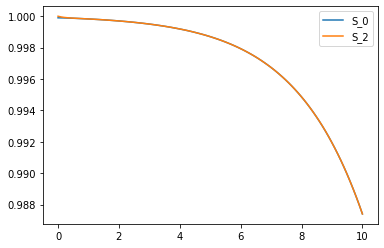

In [86]:
plt.plot(sol.t, sol.y[0], label='S_0')
plt.plot(sol.t, sol.y[2], label='S_2')
plt.legend()
plt.show()

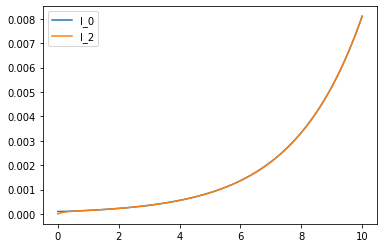

In [87]:
plt.plot(sol.t, sol.y[N_cities], label='I_0')
plt.plot(sol.t, sol.y[N_cities+2], label='I_2')
plt.legend()
plt.show()

## Calculating $R_0$

$$
\begin{align*}
\dot{S_j}(t) &= -\beta S_j(t) I_j(t) - \eta_j S_j(t) + \sum_{k \sim j} \eta_k\frac{A_{jk}}{N_k}\frac{P_k}{P_j}S_k(t - \delta_{ij}) - u_j(t)S_j(t) \\
\dot{I_j}(t) &= \beta S_j(t) I_j(t) - \eta_j I_j(t) + \sum_{k \sim j} \eta_k\frac{A_{jk}}{N_k}\frac{P_k}{P_j}I_k(t - \delta_{ij}) - \gamma I_j(t) \\
\dot{R_j}(t) &= \gamma I_j(t) - \eta_j R_j(t) + \sum_{k \sim j} \eta_k\frac{A_{jk}}{N_k}\frac{P_k}{P_j}R_k(t - \delta_{ij}) + u_j(t) S_j(t), 
\end{align*}
$$

In [10]:
s1, s2, s3, i1, i2, i3, r1, r2, r3 = sp.symbols('s_1 s_2 s_3 i_1 i_2 i_3 r_1 r_2 r_3')
beta, eta1, eta2, eta3, gamma = sp.symbols('beta eta_1 eta_2 eta_3 gamma')
A = sp.MatrixSymbol('A', 3, 3)

In [19]:
A = A.subs({A[0,0]: 0})

In [21]:
A[0,0]

A[0, 0]

In [42]:
Vc = sp.Matrix([
    [-eta1*i1 + A[0,1]*eta2*i2 + A[0,2]*eta3*i3 - gamma*i1],
    [-eta2*i2 + A[1,0]*eta1*i1 + A[1,2]*eta3*i3 - gamma*i2],
    [-eta3*i3 + A[2,0]*eta1*i1 + A[2,1]*eta2*i2 - gamma*i3]
])

V = sp.Matrix([[Vc.diff(i1), Vc.diff(i2), Vc.diff(i3)]])

In [47]:
V

Matrix([
[-eta_1 - gamma,  eta_2*A[0, 1],  eta_3*A[0, 2]],
[ eta_1*A[1, 0], -eta_2 - gamma,  eta_3*A[1, 2]],
[ eta_1*A[2, 0],  eta_2*A[2, 1], -eta_3 - gamma]])